In [3]:
#Insert needed Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from colorama import Fore

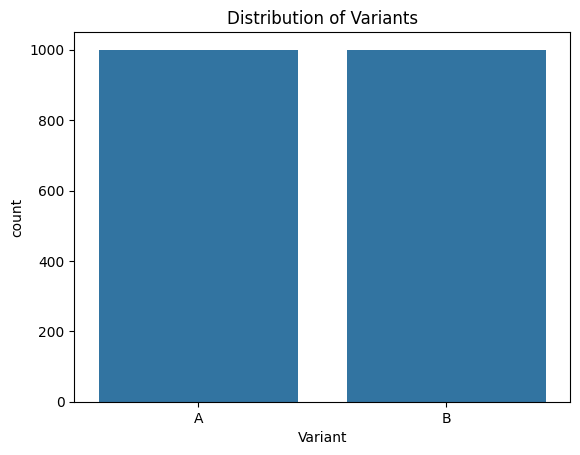

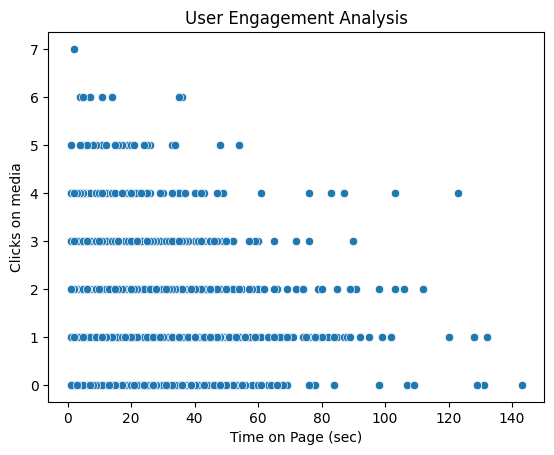

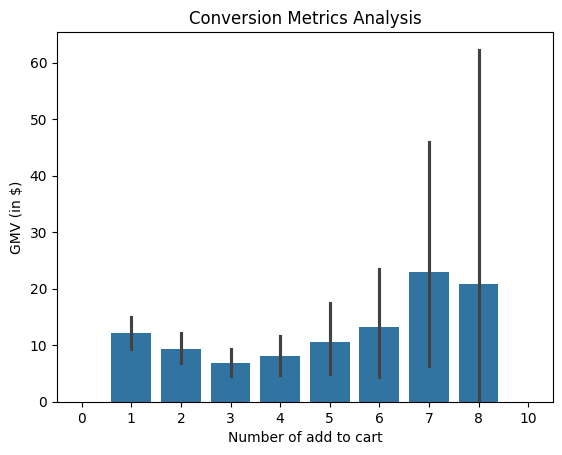

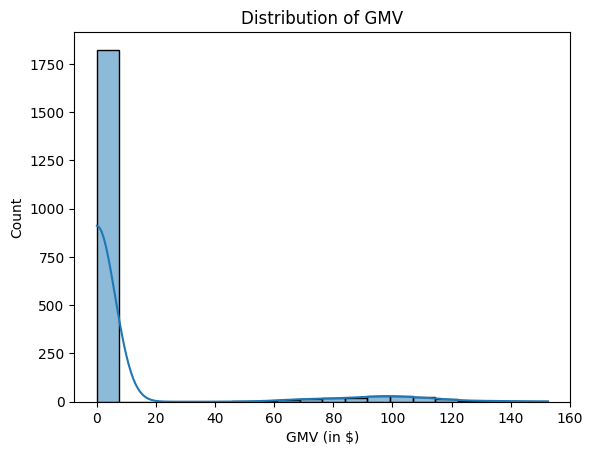

In [4]:
initial_data = pd.read_csv('assessment_da25.csv')
#  Explore Variants
sns.countplot(x='Variant', data=initial_data)
plt.title('Distribution of Variants')
plt.show()

#  User Engagement
sns.scatterplot(x='Time on Page (sec)', y='Clicks on media', data=initial_data)
plt.title('User Engagement Analysis')
plt.show()

#  Conversion Metrics
sns.barplot(x='Number of add to cart', y='GMV (in $)', data=initial_data)
plt.title('Conversion Metrics Analysis')
plt.show()

#  GMV Analysis
sns.histplot(initial_data['GMV (in $)'], bins=20, kde=True)
plt.title('Distribution of GMV')
plt.show()

In [5]:

# Get the external data as a the dataset for A/B test



In [6]:
# ETL
# clean and transform data 
initial_data['conversion_rate'] = initial_data['Number of add to cart'] / initial_data['Number of page views']
initial_data.rename(columns={'Number of page views': 'page_views'}, inplace=True)
initial_data.rename(columns={'Number of add to cart': 'num_add_to_card'}, inplace=True)
initial_data.rename(columns={'Clicks on media': 'clicks_on_media'}, inplace=True)
initial_data.rename(columns={'Time on Page (sec)': 'time_on_page(sec)'}, inplace=True)
initial_data.rename(columns={'GMV (in $)': 'GMV'}, inplace=True)

# Write the DataFrame back to the CSV file as cleaned data
initial_data.to_csv("cooking_cleaned_data.csv", index=False)

# Reloud clean data
data = pd.read_csv("cooking_cleaned_data.csv")
data.groupby('Variant').sum().head().T

Variant,A,B
page_views,4985.000000,5.317000e+03
GMV,7689.990000,9.289530e+03
num_add_to_card,1884.000000,2.469000e+03
clicks_on_media,1495.000000,1.324000e+03
time_on_page(sec),20543.000000,2.004700e+04
user_id,499500.000000,1.499500e+06
conversion_rate,503.989214,5.771912e+02


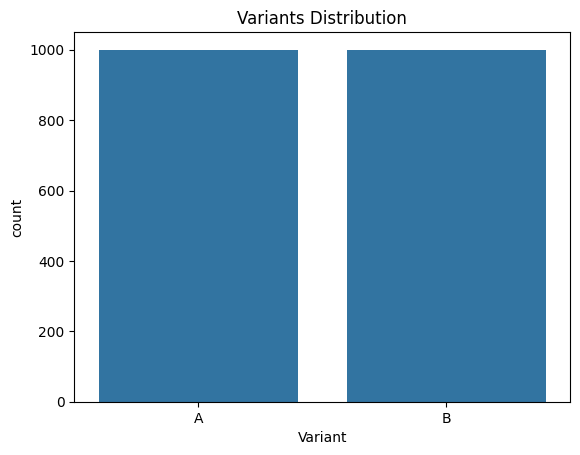

In [7]:

# What's our Variants(to be aware of sample size and deciding that the A/B test is good or not)
sns.countplot(x='Variant', data=data)
plt.title('Variants Distribution')
plt.show()


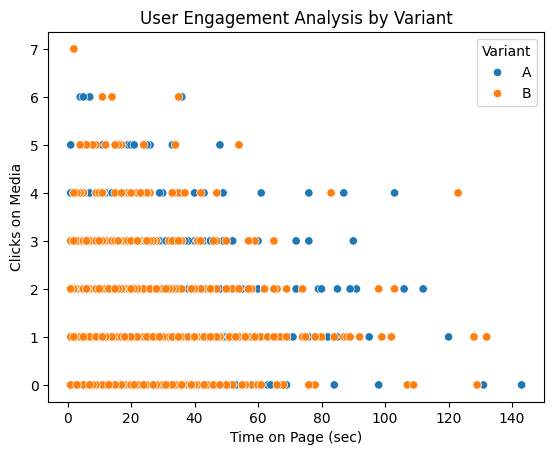

In [8]:
# User Engagement

sns.scatterplot(x='time_on_page(sec)', y='clicks_on_media', hue='Variant', data=data)
plt.title('User Engagement Analysis by Variant')
plt.xlabel('Time on Page (sec)')
plt.ylabel('Clicks on Media')
plt.legend(title='Variant')
plt.show()


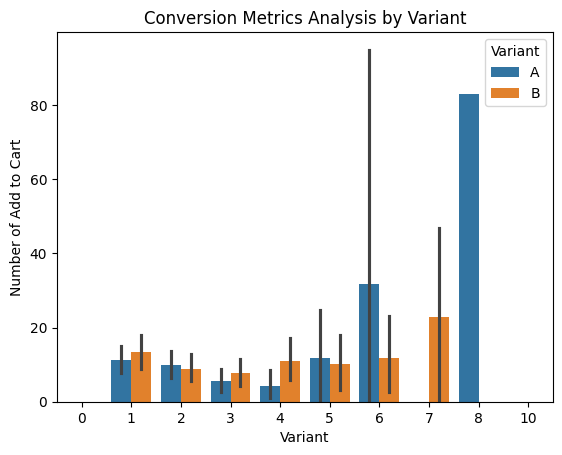

In [9]:
# Bar plot for conversion metrics analysis by Variant
sns.barplot(x='num_add_to_card', y='GMV', hue='Variant', data=data)
plt.title('Conversion Metrics Analysis by Variant')
plt.xlabel('Variant')
plt.ylabel('Number of Add to Cart')
plt.show()


In [10]:
# Define horizental and vertical by filtering data on the variant
horizental = data[data['Variant'] == 'A']
vertical = data[data['Variant'] == 'B']

# Variables
key_metrics = ['conversion_rate','page_views', 'clicks_on_media', 'time_on_page(sec)', 'num_add_to_card', 'GMV']

# Create a list to keep the results
results = []

# Loop over each variable
for key in key_metrics:
    # Filter rows where the variable is greater than 0 for each variant
    filtered_data_A = horizental[key][horizental[key] > 0]
    filtered_data_B = vertical[key][vertical[key] > 0]
    
    # Count the number of rows where the variable is greater than 0 for each variant
    amont_A = filtered_data_A.shape[0]
    amont_B = filtered_data_B.shape[0]

    # Add the result to the list
    results.append({'Variable': key, 'Variant A': amont_A, 'Variant B': amont_B})

# Create a DataFrame from the list of results
results = pd.DataFrame(results)
print(results)



            Variable  Variant A  Variant B
0    conversion_rate        857        896
1         page_views        995        993
2    clicks_on_media        780        728
3  time_on_page(sec)       1000       1000
4    num_add_to_card        857        896
5                GMV         80         97


In [11]:
# Dividing data in 2 groups considered on the variant(Horizental(A) & Vertical(B) media rail)
group_a = data[data['Variant']== 'A']
group_b = data[data['Variant'] == 'B']  

# Calculate the  mean to take a look
mean_calculation = pd.DataFrame({
    'Metric': key_metrics,
    'Mean A': [group_a[key].mean() for key in key_metrics],
    'Mean B': [group_b[key].mean() for key in key_metrics]
})

mean_calculation.head()


,Metric,Mean A,Mean B
0,conversion_rate,0.506522,0.58126
1,page_views,4.985000,5.31700
2,clicks_on_media,1.495000,1.32400
3,time_on_page(sec),20.543000,20.04700
4,num_add_to_card,1.884000,2.46900


# We have: Null-Hypathesis is using former media rail(horizental A) is better and don't need to change
# Alternative-Hypathesis is using new media rail(vertical B)
# By considering of our observation of meeans choose conversion_rate as primary metric and checking rejecting or accepting Hypathesis 
 Based on primery metric we choose z-test to analize a propotion metric

In [12]:
# calculate opportunities and conversions
cons_A = data[data['Variant'] == 'A']['num_add_to_card'].sum() #conversions 
opps_A = data[data['Variant'] == 'A']['page_views'].sum()       #opportunities 
cons_B = data[data['Variant'] == 'B']['num_add_to_card'].sum()
opps_B = data[data['Variant'] == 'B']['page_views'].sum()

conversion_rate_A = cons_A / opps_A
conversion_rate_B = cons_B / opps_B
print("Conversion Rate A: {:.3f}".format(conversion_rate_A))
print("Conversion Rate B: {:.3f}".format(conversion_rate_B))

# Perform Z-test
# Specify the 'larger' alternative parameter for a one-tailed test, indicating that the p-value of A is larger than the p-value of B.
z_stat, p_value = proportions_ztest([cons_A, cons_B], [opps_A, opps_B], alternative='larger') 
# print result
print("Z-statistic: {:.3f}".format(z_stat))
print("P-value: {:.3f}".format(p_value))


alpha =0.05
if p_value < alpha:
     print(Fore.RED,"There is a statistically meaningful distinction in the Conversion Rate between variant A and variant B.")
else:
     print(Fore.RED,"There is no statistically meaningful distinction in the Conversion Rate between variant A and variant B.")



Conversion Rate A: 0.378
Conversion Rate B: 0.464
Z-statistic: -8.875
P-value: 1.000
 There is no statistically meaningful distinction in the Conversion Rate between variant A and variant B.


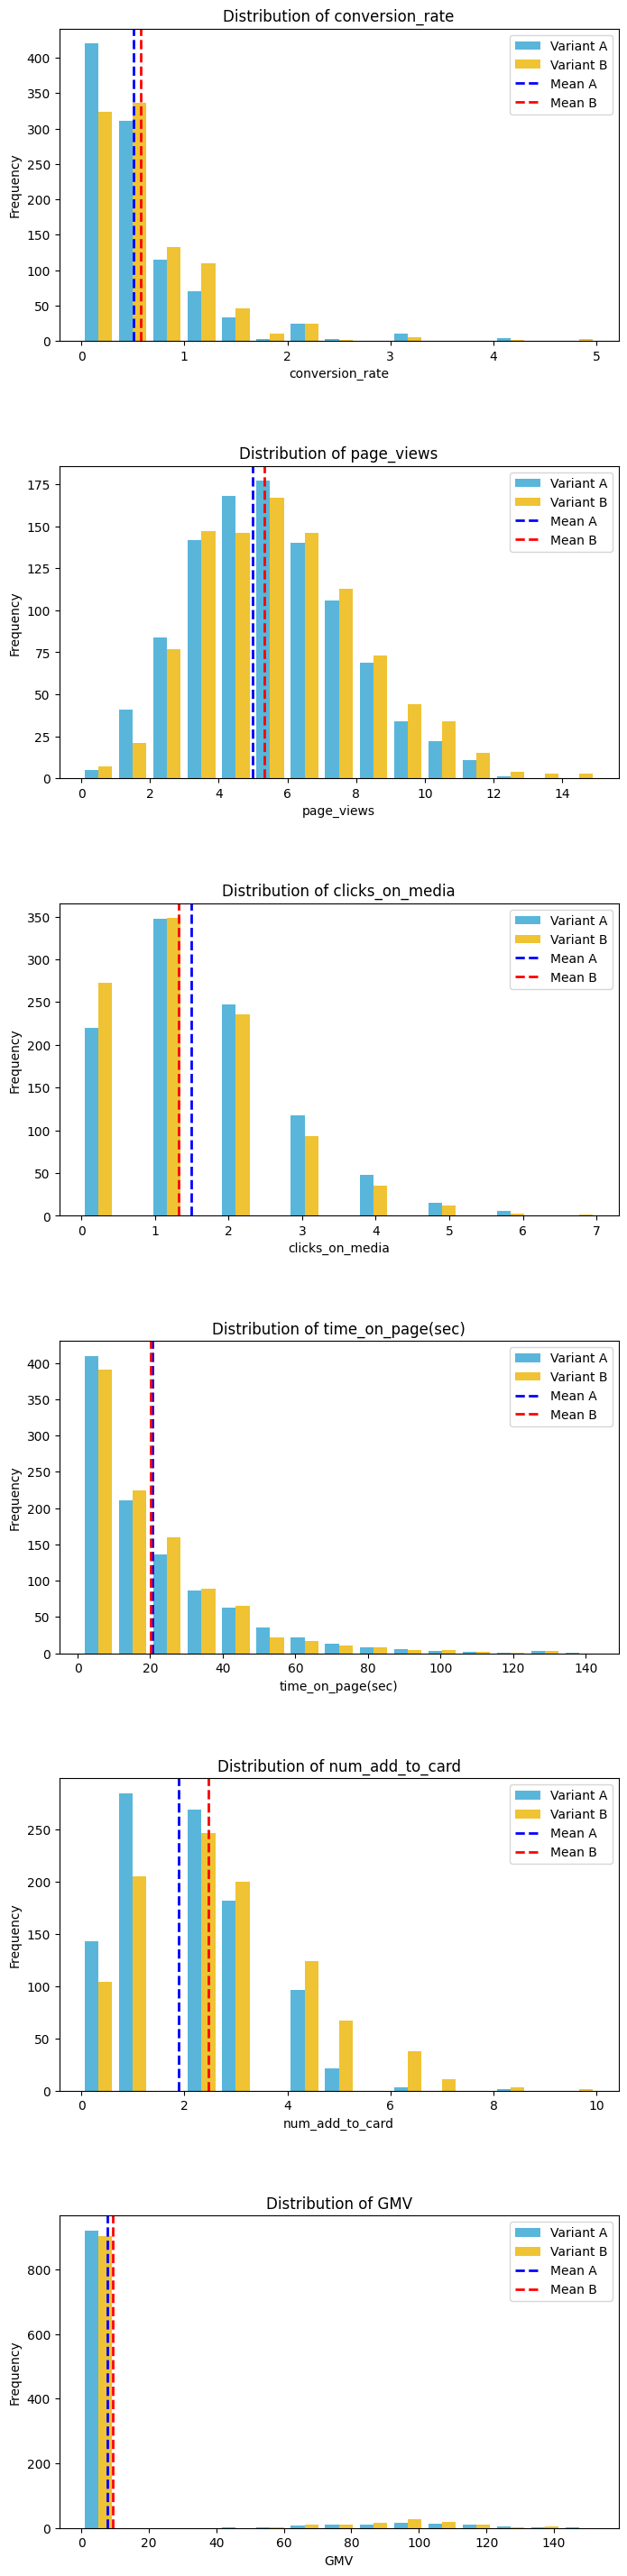

In [13]:
#Destribution of metrics

# The number of rows and columns for subplots
rows = len(key_metrics)
cols = 1  

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(8, 6 * rows))
fig.subplots_adjust(hspace=0.4)  # Space between rows

for i, key in enumerate(key_metrics):
    # Set data for variants
    data_A = data.loc[data['Variant'] == 'A', key]
    data_B = data.loc[data['Variant'] == 'B', key]

    # Plot histograms for variant A and B side by side
    axs[i].hist([data_A, data_B], bins=15, alpha=0.8, color=['#30a4d1', '#ecb500'], label=['Variant A', 'Variant B'])
    
    # Add lines for the mean of each variant
    axs[i].axvline(x=data_A.mean(), color='blue', linestyle='--', linewidth=2, label='Mean A')
    axs[i].axvline(x=data_B.mean(), color='red', linestyle='--', linewidth=2, label='Mean B')
    
    # Set labels and title 
    axs[i].set_xlabel(key)
    axs[i].set_ylabel('Frequency')
    
    # Add legend and title
    axs[i].legend()
    axs[i].set_title("Distribution of {}".format(key))

# Show the plot
plt.show()

In [91]:
# Perform t-tests for all metrics 

# Initialize a dictionary to hold test results
results = {}

# Perform t-tests for continuous metrics (GMV, Time on Page)
for metric in key_metrics:
    stat, p_value = ttest_ind(group_a[metric].dropna(), group_b[metric].dropna(), equal_var=False)
    results[metric] = {'statistic': stat, 'p_value': p_value}


pd.DataFrame(results).T


,statistic,p_value
conversion_rate,-3.009093,2.653244e-03
page_views,-3.188165,1.454076e-03
clicks_on_media,3.171070,1.541858e-03
time_on_page(sec),0.555430,5.786630e-01
num_add_to_card,-8.777389,3.668899e-18
GMV,-1.283954,1.993078e-01
